In [1]:
# import the pakages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import kpss as KPSS
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox as box
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  mean_absolute_percentage_error
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import arma_order_select_ic as ORDER
from plotnine import * 
from statsmodels.tsa.api import ExponentialSmoothing as es
import statsmodels.formula.api as smf
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import LassoLars
import xgboost
from sklearn.ensemble import VotingRegressor
from scipy import stats as st
import lightgbm as lgb
%matplotlib inline

In [2]:
# import the dataset
a1 = pd.read_csv('ab_2data.csv')[['id','date', 'neighbourhood_group','room_type', 'price', 'minimum_nights', 'availability_365', 'month_review']]
a1['date'] = pd.to_datetime(a1['date'])
a1 = a1.set_index(a1.date)
a1.head()

,id,date,neighbourhood_group,room_type,price,minimum_nights,availability_365,month_review
date,,,,,,,,
2018-04-01,109,2018-04-01,Other Cities,Entire home/apt,122,7,0.0,0.0
2018-05-01,109,2018-05-01,Other Cities,Entire home/apt,122,7,25.0,0.0
2018-06-01,109,2018-06-01,Other Cities,Entire home/apt,122,7,52.0,0.0
2018-07-01,109,2018-07-01,Other Cities,Entire home/apt,122,7,82.0,0.0
2018-08-01,109,2018-08-01,Other Cities,Entire home/apt,122,7,114.0,0.0


In [3]:
a1['year'] = a1.index.year
a1['quarter'] = a1.index.quarter
a1['month'] = a1.index.month
a1.head()

,id,date,neighbourhood_group,room_type,price,minimum_nights,availability_365,month_review,year,quarter,month
date,,,,,,,,,,,
2018-04-01,109,2018-04-01,Other Cities,Entire home/apt,122,7,0.0,0.0,2018,2,4
2018-05-01,109,2018-05-01,Other Cities,Entire home/apt,122,7,25.0,0.0,2018,2,5
2018-06-01,109,2018-06-01,Other Cities,Entire home/apt,122,7,52.0,0.0,2018,2,6
2018-07-01,109,2018-07-01,Other Cities,Entire home/apt,122,7,82.0,0.0,2018,3,7
2018-08-01,109,2018-08-01,Other Cities,Entire home/apt,122,7,114.0,0.0,2018,3,8


<AxesSubplot:xlabel='date'>

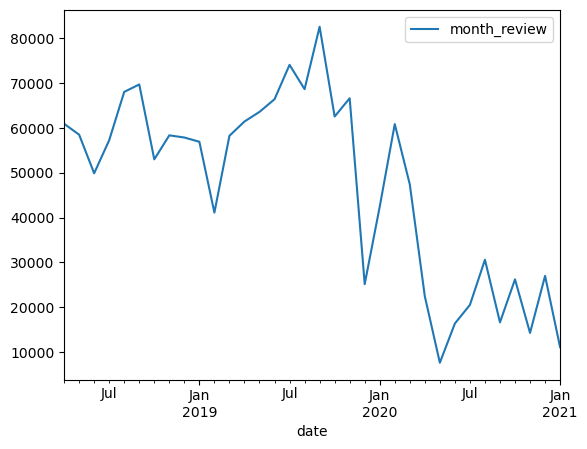

In [4]:
at = a1[['month_review']].groupby(a1['date']).sum()
at.plot()

<AxesSubplot:xlabel='quarter'>

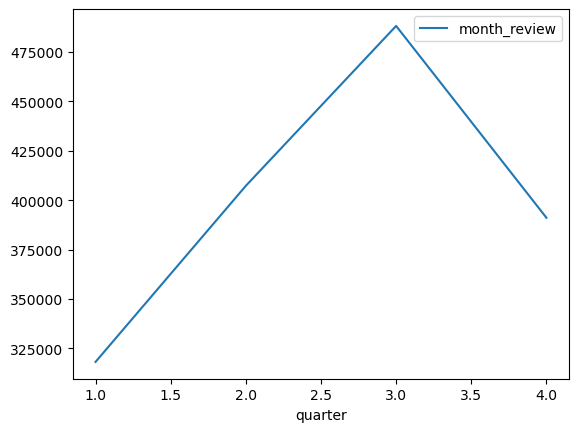

In [5]:
aq = a1[['month_review']].groupby(a1['quarter']).sum()
aq.plot()

<AxesSubplot:xlabel='month'>

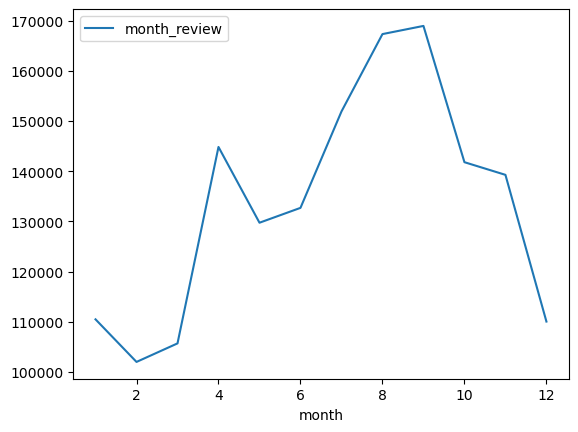

In [6]:
am = a1[['month_review']].groupby(a1['month']).sum()
am.plot()

In [7]:
a1 = a1.loc[a1['month_review']>=0].copy()
a1.head()

,id,date,neighbourhood_group,room_type,price,minimum_nights,availability_365,month_review,year,quarter,month
date,,,,,,,,,,,
2018-04-01,109,2018-04-01,Other Cities,Entire home/apt,122,7,0.0,0.0,2018,2,4
2018-05-01,109,2018-05-01,Other Cities,Entire home/apt,122,7,25.0,0.0,2018,2,5
2018-06-01,109,2018-06-01,Other Cities,Entire home/apt,122,7,52.0,0.0,2018,2,6
2018-07-01,109,2018-07-01,Other Cities,Entire home/apt,122,7,82.0,0.0,2018,3,7
2018-08-01,109,2018-08-01,Other Cities,Entire home/apt,122,7,114.0,0.0,2018,3,8


In [8]:
a1['covid'] = 0
a1.loc[a1['date']>='2020-03-01','covid'] = 1
a1['drop'] = 0 
a1.loc['2019-11-01':'2019-12-01','drop'] = 1

In [9]:
a1 = a1.loc[a1['month_review']<=30].copy()

In [10]:
a1

,id,date,neighbourhood_group,room_type,price,minimum_nights,availability_365,month_review,year,quarter,month,covid,drop
date,,,,,,,,,,,,,
2018-04-01,109,2018-04-01,Other Cities,Entire home/apt,122,7,0.0,0.0,2018,2,4,0,0
2018-05-01,109,2018-05-01,Other Cities,Entire home/apt,122,7,25.0,0.0,2018,2,5,0,0
2018-06-01,109,2018-06-01,Other Cities,Entire home/apt,122,7,52.0,0.0,2018,2,6,0,0
2018-07-01,109,2018-07-01,Other Cities,Entire home/apt,122,7,82.0,0.0,2018,3,7,0,0
2018-08-01,109,2018-08-01,Other Cities,Entire home/apt,122,7,114.0,0.0,2018,3,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,47028232,2021-01-01,Unincorporated Areas,Private room,59,1,364.0,0.0,2021,1,1,1,0
2021-01-01,47028235,2021-01-01,City of Los Angeles,Private room,35,30,7.0,0.0,2021,1,1,1,0
2021-01-01,47028602,2021-01-01,City of Los Angeles,Private room,32,30,43.0,0.0,2021,1,1,1,0


# T-test on Covid's Affect

In [11]:
bmr = a1.loc[(a1['covid']==0), 'month_review']
amr = a1.loc[(a1['covid']==1), 'month_review']
dc = amr.sum()/bmr.sum() - 1
tstat = st.ttest_ind(a=bmr, b=amr, equal_var=True)
print(dc*100, tstat)

-82.25634833959681 Ttest_indResult(statistic=183.8146326405328, pvalue=0.0)


In [12]:
ng = ['City of Los Angeles','Other Cities','Unincorporated Areas']
rt = ['Entire home/apt','Private room','Shared room','Hotel room']
ft = ['price','availability_365','minimum_nights']

for i in ng:
    bmr = a1.loc[(a1['neighbourhood_group']==i)&(a1['covid']==0), 'month_review']
    amr = a1.loc[(a1['neighbourhood_group']==i)&(a1['covid']==1), 'month_review']
    dc = amr.sum()/bmr.sum() - 1
    tstat = st.ttest_ind(a=bmr, b=amr, equal_var=True)
    print(i, dc*100, tstat)

City of Los Angeles -87.25293713809124 Ttest_indResult(statistic=163.54465816935826, pvalue=0.0)
Other Cities -73.33495309441858 Ttest_indResult(statistic=86.05885019286212, pvalue=0.0)
Unincorporated Areas -67.4868968232486 Ttest_indResult(statistic=34.170952936167204, pvalue=4.359372383124504e-254)


In [13]:
for i in rt:
    bmr = a1.loc[(a1['room_type']==i)&(a1['covid']==0), 'month_review']
    amr = a1.loc[(a1['room_type']==i)&(a1['covid']==1), 'month_review']
    dc = amr.sum()/bmr.sum() - 1
    tstat = st.ttest_ind(a=bmr, b=amr, equal_var=True)
    print(i, dc*100, tstat)

Entire home/apt -80.11790834274476 Ttest_indResult(statistic=143.06272673609374, pvalue=0.0)
Private room -86.8948366595913 Ttest_indResult(statistic=114.5821311179236, pvalue=0.0)
Shared room -89.49609131280508 Ttest_indResult(statistic=32.65859663765608, pvalue=1.8961477924929776e-231)
Hotel room -58.21336286452565 Ttest_indResult(statistic=11.337658385510721, pvalue=2.4932919720220837e-29)


In [14]:
ap = a1.copy()
ap = ap.reset_index(drop=True)
ap = ap.set_index(['id'])
ap['avgprice'] = ap['price'].groupby('id').mean()
ap['price_t'] = ['Low' if i<=200 else 'High' for i in ap['avgprice']]

In [15]:
pt = ['Low','High']
for i in pt:
    bmr = ap.loc[(ap['price_t']==i)&(ap['covid']==0), 'month_review']
    amr = ap.loc[(ap['price_t']==i)&(ap['covid']==1), 'month_review']
    dc = amr.sum()/bmr.sum() - 1
    tstat = st.ttest_ind(a=bmr, b=amr, equal_var=True)
    print(i, dc*100, tstat)

Low -83.692742550376 Ttest_indResult(statistic=177.28508955128785, pvalue=0.0)
High -73.86916643505066 Ttest_indResult(statistic=51.15685438105945, pvalue=0.0)


# RG - each record as input

In [16]:
m1 = smf.ols('month_review ~ price + minimum_nights + availability_365 + C(quarter) + C(month) + C(year)', a1).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           month_review   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3642.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:34:34   Log-Likelihood:            -2.8287e+06
No. Observations:             1277474   AIC:                         5.657e+06
Df Residuals:                 1277456   BIC:                         5.658e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.5416      0.010    159.599      0.000       1.523       1.561
C(quarter)[T.2]  -2.325e+08   6.72e+08     -0.346      0.729   -1.55e+09    1.08e+09
C(quarter)[T.3]   5.517e+08   5.64e+08      0.978      0.328   -5.54e+08    1.66e+09
C(quarter)[T.4]  -4.698e+07   1.14e+09     -0.041      0.967   -2.28e+09    2.19e+09
C(month)[T.2]       -0.0033      0.011     -0.294      0.769      -0.025       0.019
C(month)[T.3]        0.0873      0.011      7.768      0.000       0.065       0.109
C(month)[T.4]     2.325e+08   6.72e+08      0.346      0.729   -1.08e+09    1.55e+09
C(month)[T.5]     2.325e+08   6.72e+08      0.346      0.729   -1.08e+09    1.55e+09
C(month)[T.6]     2.325e+08   6.72e+08      0.346      0.729   -1.08e+09    1.55e+09
C(month)[T.7]    -5.517e+08   5.64e+08     -0.978      0.328   -1.66e+09    5.54e+08
C(month)[T.8]    -5.517e+08   5.64e+08     -0.978      0.328   -1.66e+09    5.54e+08
C(month)[T.9]    -5.517e+08   5.64e+08     -0.978      0.328   -1.66e+09    5.54e+08
C(month)[T.10]    4.698e+07   1.14e+09      0.041      0.967   -2.19e+09    2.28e+09
C(month)[T.11]    4.698e+07   1.14e+09      0.041      0.967   -2.19e+09    2.28e+09
C(month)[T.12]    4.698e+07   1.14e+09      0.041      0.967   -2.19e+09    2.28e+09
C(year)[T.2019]     -0.0372      0.005     -7.316      0.000      -0.047      -0.027
C(year)[T.2020]     -0.6103      0.005   -112.966      0.000      -0.621      -0.600
C(year)[T.2021]     -1.1099      0.016    -71.118      0.000      -1.140      -1.079
price               -0.0003   3.48e-06    -76.191      0.000      -0.000      -0.000
minimum_nights      -0.0103    8.1e-05   -127.204      0.000      -0.010      -0.010
availability_365     0.0011   1.42e-05     76.611      0.000       0.001       0.001
==============================================================================
Omnibus:                   736736.668   Durbin-Watson:                   0.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7364446.033
Skew:                           2.651   Prob(JB):                         0.00
Kurtosis:                      13.500   Cond. No.                     7.07e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.44e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [17]:
# delete the quarter, add the covid
m2 = smf.ols('month_review ~ price + minimum_nights + availability_365 + C(quarter) + C(month) + C(year) + C(covid)', a1).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           month_review   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3820.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:34:45   Log-Likelihood:            -2.8254e+06
No. Observations:             1277474   AIC:                         5.651e+06
Df Residuals:                 1277455   BIC:                         5.651e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0646      0.011     94.131      0.000       1.042       1.087
C(quarter)[T.2]  -2.334e+08    6.7e+08     -0.348      0.728   -1.55e+09    1.08e+09
C(quarter)[T.3]   4.728e+08   5.63e+08      0.840      0.401    -6.3e+08    1.58e+09
C(quarter)[T.4]  -4.082e+07   1.14e+09     -0.036      0.971   -2.27e+09    2.19e+09
C(month)[T.2]        0.0104      0.011      0.934      0.350      -0.011       0.032
C(month)[T.3]        0.5672      0.013     44.704      0.000       0.542       0.592
C(month)[T.4]     2.334e+08    6.7e+08      0.348      0.728   -1.08e+09    1.55e+09
C(month)[T.5]     2.334e+08    6.7e+08      0.348      0.728   -1.08e+09    1.55e+09
C(month)[T.6]     2.334e+08    6.7e+08      0.348      0.728   -1.08e+09    1.55e+09
C(month)[T.7]    -4.728e+08   5.63e+08     -0.840      0.401   -1.58e+09     6.3e+08
C(month)[T.8]    -4.728e+08   5.63e+08     -0.840      0.401   -1.58e+09     6.3e+08
C(month)[T.9]    -4.728e+08   5.63e+08     -0.840      0.401   -1.58e+09     6.3e+08
C(month)[T.10]    4.082e+07   1.14e+09      0.036      0.971   -2.19e+09    2.27e+09
C(month)[T.11]    4.082e+07   1.14e+09      0.036      0.971   -2.19e+09    2.27e+09
C(month)[T.12]    4.082e+07   1.14e+09      0.036      0.971   -2.19e+09    2.27e+09
C(year)[T.2019]      0.0399      0.005      7.736      0.000       0.030       0.050
C(year)[T.2020]      0.2871      0.012     23.252      0.000       0.263       0.311
C(year)[T.2021]      0.3596      0.024     15.020      0.000       0.313       0.407
C(covid)[T.1]       -0.9963      0.012    -80.782      0.000      -1.021      -0.972
price               -0.0003   3.47e-06    -76.749      0.000      -0.000      -0.000
minimum_nights      -0.0102   8.08e-05   -126.450      0.000      -0.010      -0.010
availability_365     0.0011   1.41e-05     77.991      0.000       0.001       0.001
==============================================================================
Omnibus:                   735069.940   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7368154.389
Skew:                           2.642   Prob(JB):                         0.00
Kurtosis:                      13.512   Cond. No.                     7.07e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.44e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
# add some categorical variables
m3 = smf.ols('month_review ~ price + minimum_nights + availability_365 + \
             + C(neighbourhood_group) + C(room_type) + C(quarter) + C(month) + C(year) + C(covid)', a1).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           month_review   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3706.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:34:59   Log-Likelihood:            -2.8176e+06
No. Observations:             1277474   AIC:                         5.635e+06
Df Residuals:                 1277450   BIC:                         5.636e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          1.2441      0.011    109.851      0.000       1.222       1.266
C(neighbourhood_group)[T.Other Cities]             0.0443      0.004     10.148      0.000       0.036       0.053
C(neighbourhood_group)[T.Unincorporated Areas]     0.1234      0.008     15.094      0.000       0.107       0.139
C(room_type)[T.Hotel room]                        -0.3425      0.036     -9.614      0.000      -0.412      -0.273
C(room_type)[T.Private room]                      -0.4241      0.004    -99.509      0.000      -0.432      -0.416
C(room_type)[T.Shared room]                       -0.9097      0.010    -88.438      0.000      -0.930      -0.890
C(quarter)[T.2]                                -4.945e+08    1.1e+09     -0.450      0.653   -2.65e+09    1.66e+09
C(quarter)[T.3]                                 2.357e+07   5.24e+07      0.450      0.653   -7.92e+07    1.26e+08
C(quarter)[T.4]                                -5.555e+06   1.24e+07     -0.450      0.653   -2.98e+07    1.87e+07
C(month)[T.2]                                      0.0110      0.011      0.991      0.322      -0.011       0.033
C(month)[T.3]                                      0.5664      0.013     44.911      0.000       0.542       0.591
C(month)[T.4]                                   4.945e+08    1.1e+09      0.450      0.653   -1.66e+09    2.65e+09
C(month)[T.5]                                   4.945e+08    1.1e+09      0.450      0.653   -1.66e+09    2.65e+09
C(month)[T.6]                                   4.945e+08    1.1e+09      0.450      0.653   -1.66e+09    2.65e+09
C(month)[T.7]                                  -2.357e+07   5.24e+07     -0.450      0.653   -1.26e+08    7.92e+07
C(month)[T.8]                                  -2.357e+07   5.24e+07     -0.450      0.653   -1.26e+08    7.92e+07
C(month)[T.9]                                  -2.357e+07   5.24e+07     -0.450      0.653   -1.26e+08    7.92e+07
C(month)[T.10]                                  5.555e+06   1.24e+07      0.450      0.653   -1.87e+07    2.98e+07
C(month)[T.11]                                  5.555e+06   1.24e+07      0.450      0.653   -1.87e+07    2.98e+07
C(month)[T.12]                                  5.555e+06   1.24e+07      0.450      0.653   -1.87e+07    2.98e+07
C(year)[T.2019]                                    0.0300      0.005      5.842      0.000       0.020       0.040
C(year)[T.2020]                                    0.2724      0.012     22.167      0.000       0.248       0.297
C(year)[T.2021]                                    0.3356      0.024     14.094      0.000       0.289       0.382
C(covid)[T.1]                                     -0.9958      0.012    -81.219      0.000   

# Regression-Aggregated by Room-type/Neighborhood Group

## By month

In [19]:
# it looks not imporssible to built model for each record, try avg level
# make dummy for categorical variable
h = a1.copy()
h.head()

,id,date,neighbourhood_group,room_type,price,minimum_nights,availability_365,month_review,year,quarter,month,covid,drop
date,,,,,,,,,,,,,
2018-04-01,109,2018-04-01,Other Cities,Entire home/apt,122,7,0.0,0.0,2018,2,4,0,0
2018-05-01,109,2018-05-01,Other Cities,Entire home/apt,122,7,25.0,0.0,2018,2,5,0,0
2018-06-01,109,2018-06-01,Other Cities,Entire home/apt,122,7,52.0,0.0,2018,2,6,0,0
2018-07-01,109,2018-07-01,Other Cities,Entire home/apt,122,7,82.0,0.0,2018,3,7,0,0
2018-08-01,109,2018-08-01,Other Cities,Entire home/apt,122,7,114.0,0.0,2018,3,8,0,0


In [20]:
h.shape

(1277474, 13)

In [21]:
col = list(h.columns)
col.remove('month_review')
h = h.reset_index(drop=True)
h1 = h.groupby(['date'])[col].mean()
h1_ = h.groupby(['date'])[['month_review']].sum()
h1 = h1.join(h1_,how='left',on='date')
h1

,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review
date,,,,,,,,,,
2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0
2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0
2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0
2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0
2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0
2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0
2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0
2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0
2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0


In [22]:
h1.columns

Index(['id', 'price', 'minimum_nights', 'availability_365', 'year', 'quarter',
       'month', 'covid', 'drop', 'month_review'],
      dtype='object')

In [23]:
h1

,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review
date,,,,,,,,,,
2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0
2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0
2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0
2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0
2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0
2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0
2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0
2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0
2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0


In [24]:
h1 = h1.reset_index()
h1

,date,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review
0,2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0
1,2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0
2,2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0
3,2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0
4,2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0
5,2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0
6,2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0
7,2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0
8,2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0
9,2019-01-01,1.784664e+07,196.825384,5.287266,172.308411,2019.0,1.0,1.0,0.0,0.0,56879.0


In [25]:
trn = h1.iloc[:31,:]
tst = h1.iloc[31:,:]

## Modeling and Prediction

In [26]:
m4 = smf.ols('month_review ~ price + minimum_nights + availability_365 + \
             C(quarter) + C(month) + C(covid) + C(drop)', trn).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           month_review   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     5.265
Date:                Thu, 16 Feb 2023   Prob (F-statistic):            0.00162
Time:                        14:34:59   Log-Likelihood:                -319.52
No. Observations:                  31   AIC:                             673.0
Df Residuals:                      14   BIC:                             697.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.319e+05   1.52e+05      0.865      0.401   -1.95e+05    4.59e+05
C(quarter)[T.2.0]  2409.1588   9002.725      0.268      0.793   -1.69e+04    2.17e+04
C(quarter)[T.3.0]  1.042e+04   8128.836      1.282      0.221   -7010.714    2.79e+04
C(quarter)[T.4.0]  8482.4579   7534.034      1.126      0.279   -7676.437    2.46e+04
C(month)[T.2.0]     739.6803    1.1e+04      0.067      0.947   -2.28e+04    2.42e+04
C(month)[T.3.0]     1.95e+04    1.4e+04      1.397      0.184   -1.04e+04    4.94e+04
C(month)[T.4.0]    3768.1748   5921.102      0.636      0.535   -8931.326    1.65e+04
C(month)[T.5.0]   -1206.6876   5920.781     -0.204      0.841   -1.39e+04    1.15e+04
C(month)[T.6.0]    -152.3284   5898.531     -0.026      0.980   -1.28e+04    1.25e+04
C(month)[T.7.0]   -2185.5431   6572.052     -0.333      0.744   -1.63e+04    1.19e+04
C(month)[T.8.0]    4017.2855   6261.787      0.642      0.532   -9412.911    1.74e+04
C(month)[T.9.0]    8592.1630   5776.530      1.487      0.159   -3797.262     2.1e+04
C(month)[T.10.0]   2277.2180   7450.352      0.306      0.764   -1.37e+04    1.83e+04
C(month)[T.11.0]   1.463e+04   7695.523      1.901      0.078   -1878.777    3.11e+04
C(month)[T.12.0]  -8421.2382   7269.299     -1.158      0.266    -2.4e+04    7169.858
C(covid)[T.1.0]   -3.186e+04   1.65e+04     -1.926      0.075   -6.73e+04    3622.144
C(drop)[T.1.0]    -1.835e+04   1.35e+04     -1.362      0.195   -4.72e+04    1.05e+04
price               206.8080    310.370      0.666      0.516    -458.869     872.485
minimum_nights    -1363.7325   1568.466     -0.869      0.399   -4727.757    2000.292
availability_365   -681.0698    631.349     -1.079      0.299   -2035.178     673.038
==============================================================================
Omnibus:                        5.138   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                1.784
Skew:                           0.014   Prob(JB):                        0.410
Kurtosis:                       1.825   Cond. No.                     4.95e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.05e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<AxesSubplot:>

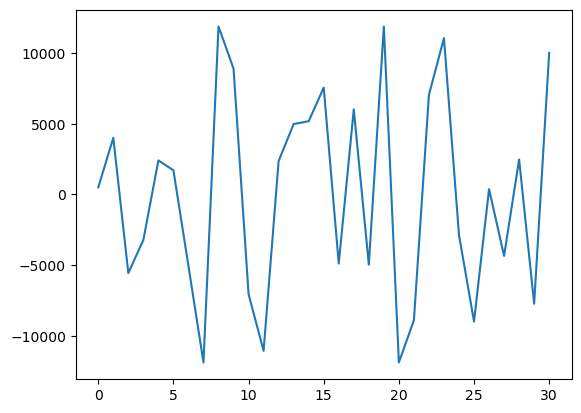

In [27]:
h1.loc[:31,'p4'] = m4.fittedvalues
h1.loc[31:,'p4'] = m4.predict(h1.iloc[31:,:])
h1['res4'] = m4.resid
h1['res4'].plot()

In [28]:
h1

,date,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review,p4,res4
0,2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0,55650.658188,498.341812
1,2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0,53774.729165,4002.270835
2,2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0,55020.359973,-5552.359973
3,2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0,60197.597002,-3213.597002
4,2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0,65003.530344,2405.469656
5,2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0,67485.760774,1708.239226
6,2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0,57875.351546,-5051.351546
7,2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0,70170.866961,-11865.866961
8,2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0,45825.133039,11865.866961
9,2019-01-01,1.784664e+07,196.825384,5.287266,172.308411,2019.0,1.0,1.0,0.0,0.0,56879.0,47992.873125,8886.126875


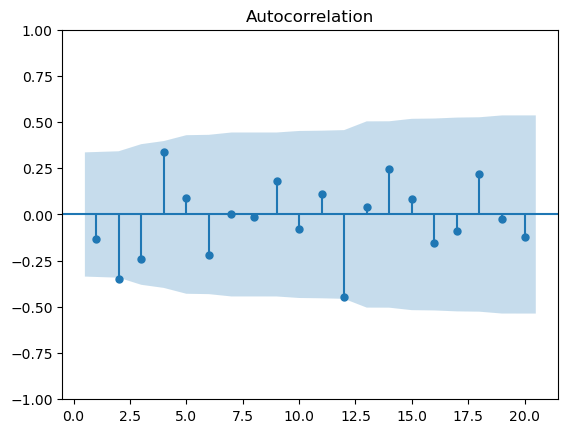

In [29]:
plot_acf(h1['res4'],lags=20, missing='drop',zero=False);
# significnat white noise

In [30]:
def accuracy(train_a,train_p):
    
    metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'], index=['DS'])

    metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'], index=['DS'])
    metrics.loc['DS','RMSE'] = (((train_a - train_p)**2).mean())**0.5
    metrics.loc['DS','MAPE(%)'] = (abs((train_a - train_p)/train_a)).mean()*100
    
    return metrics

In [31]:
def accuracy2(train_a,train_p):
    trn_a = train_a.iloc[:31]
    tst_a = train_a.iloc[31:]
    
    trn_p = train_p.iloc[:31]
    tst_p = train_p.iloc[31:]
    
    metrics = pd.DataFrame(columns=['MAPE(%)'], index=['trn','tst'])

    metrics = pd.DataFrame(columns=['MAPE(%)'], index=['trn','tst'])

    metrics.loc['trn','MAPE(%)'] = (abs((trn_a - trn_p)/trn_a)).mean()*100
    metrics.loc['tst','MAPE(%)'] = (abs((tst_a - tst_p)/tst_a)).mean()*100
    
    return metrics

In [32]:
accuracy2(h1['month_review'],h1['p4'])

,MAPE(%)
trn,17.791288
tst,52.193493


In [33]:
h1.columns

Index(['date', 'id', 'price', 'minimum_nights', 'availability_365', 'year',
       'quarter', 'month', 'covid', 'drop', 'month_review', 'p4', 'res4'],
      dtype='object')

<AxesSubplot:>

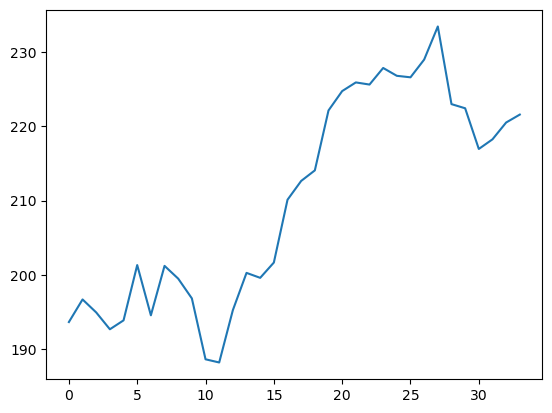

In [34]:
h1['price'].plot()

<AxesSubplot:>

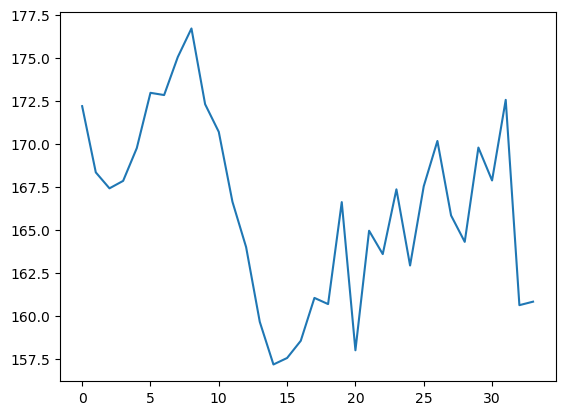

In [35]:
h1['availability_365'].plot()

In [42]:
# use smoothing method to predict each feature and use predicted features to predict month_review
feature = list(h1.columns)

f = pd.DataFrame(columns=feature)
f['year'] = pd.Series([2021]*11)
f['month'] = list(range(2,13))
f['quarter'] = [2,3,4,1,2,3,4,1,2,3,4]
f['date']= f['year'].astype(str)+'-'+f['month'].astype(str)
f['date']= pd.to_datetime(f['date'])
f['drop']=0
f['covid']=[1,1,0,0,0,0,0,0,0,0,0]

h2 = h1.copy()
h2 = pd.concat([h2, f], ignore_index = True)


fixed = ['year','month','quarter','covid','drop','id','p5','res5','p4','res4','month_review','date']
p_feature = [i for i in feature if i not in fixed]


for i in p_feature:
    m = es(h1[i],trend='add',seasonal='add',seasonal_periods=12).fit()
    h2.loc[(len(h2) - 11):,i] = m.forecast(11).values

h2

,date,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review,p4,res4
0,2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0,55650.658188,498.341812
1,2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0,53774.729165,4002.270835
2,2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0,55020.359973,-5552.359973
3,2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0,60197.597002,-3213.597002
4,2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0,65003.530344,2405.469656
5,2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0,67485.760774,1708.239226
6,2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0,57875.351546,-5051.351546
7,2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0,70170.866961,-11865.866961
8,2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0,45825.133039,11865.866961
9,2019-01-01,1.784664e+07,196.825384,5.287266,172.308411,2019.0,1.0,1.0,0.0,0.0,56879.0,47992.873125,8886.126875


In [43]:
h2.loc[(len(h2) - 14):,'pred'] = m4.predict(h2)
h2

,date,id,price,minimum_nights,availability_365,year,quarter,month,covid,drop,month_review,p4,res4,pred
0,2018-04-01,1.407663e+07,193.641824,3.775054,172.195963,2018.0,2.0,4.0,0.0,0.0,56149.0,55650.658188,498.341812,NaN
1,2018-05-01,1.445083e+07,196.684791,3.889074,168.341560,2018.0,2.0,5.0,0.0,0.0,57777.0,53774.729165,4002.270835,NaN
2,2018-06-01,1.486668e+07,194.933827,3.946959,167.413132,2018.0,2.0,6.0,0.0,0.0,49468.0,55020.359973,-5552.359973,NaN
3,2018-07-01,1.522124e+07,192.669823,3.976594,167.847253,2018.0,3.0,7.0,0.0,0.0,56984.0,60197.597002,-3213.597002,NaN
4,2018-08-01,1.561119e+07,193.870025,4.229928,169.755467,2018.0,3.0,8.0,0.0,0.0,67409.0,65003.530344,2405.469656,NaN
5,2018-09-01,1.611851e+07,201.309719,5.286727,172.971061,2018.0,3.0,9.0,0.0,0.0,69194.0,67485.760774,1708.239226,NaN
6,2018-10-01,1.661299e+07,194.550348,5.319293,172.841432,2018.0,4.0,10.0,0.0,0.0,52824.0,57875.351546,-5051.351546,NaN
7,2018-11-01,1.695920e+07,201.202455,5.262849,175.053288,2018.0,4.0,11.0,0.0,0.0,58305.0,70170.866961,-11865.866961,NaN
8,2018-12-01,1.731587e+07,199.484044,5.124208,176.714946,2018.0,4.0,12.0,0.0,0.0,57691.0,45825.133039,11865.866961,NaN
9,2019-01-01,1.784664e+07,196.825384,5.287266,172.308411,2019.0,1.0,1.0,0.0,0.0,56879.0,47992.873125,8886.126875,NaN


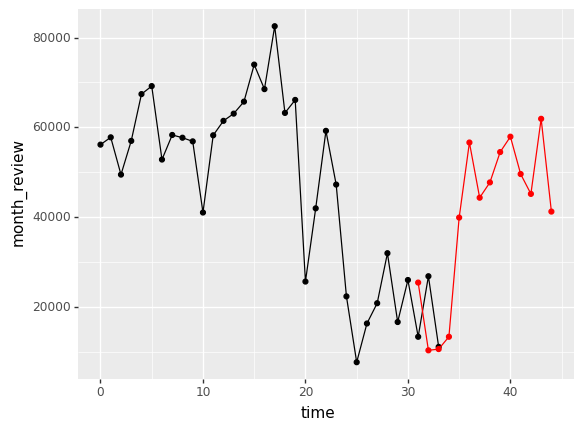

<ggplot: (341211639)>

In [46]:
h2['time'] = list(range(0,len(h2)))
(ggplot(h2.loc[:(len(h2)-12),],aes('time','month_review')) + geom_line() + geom_point() + 
 geom_line(h2.loc[(len(h2)-14):,], aes('time','pred'),color ='red') + 
 geom_point(h2.loc[(len(h2)-14):,], aes('time','pred'),color ='red')
)

## By Room type/Neighborhood Group

In [50]:
ng = ['City of Los Angeles','Other Cities','Unincorporated Areas']
rt = ['Entire home/apt','Private room','Shared room']
ft = ['price','availability_365','minimum_nights']

a2 = a1.reset_index(drop=True)
df_p_1 = a2.groupby(['date','neighbourhood_group','room_type'])[['price','availability_365','minimum_nights','year','month','covid','drop']].mean()
df_p_2 = a2.groupby(['date','neighbourhood_group','room_type'])[['month_review']].sum()
df_p = df_p_1.join(df_p_2, how='left',on=['date','neighbourhood_group','room_type'])
df_p = df_p.reset_index()
outdf = pd.DataFrame()

for i in ng:
    for j in rt:
        if i=='Unincorporated Areas' and j=='Hotel room':
            continue
        else:            
            
            # pred df
            f = pd.DataFrame(columns=['date','neighbourhood_group','room_type', 'price','availability_365','minimum_nights','year','month'])
            f['year'] = pd.Series([2021]*11)
            f['month'] = list(range(2,13))
            f['date']= f['year'].astype(str)+'-'+f['month'].astype(str)
            f['date']= pd.to_datetime(f['date'])
            f['drop']=0
            f['covid']=[1,1,0,0,0,0,0,0,0,0,0]
            f['neighbourhood_group'],f['room_type'] = i,j
            
            # pred model
            for n in ft:            
                df = a1.loc[(a1['neighbourhood_group']==i) & (a1['room_type']==j)]
                df = df.drop('date',axis=1)
                s = df.groupby('date')[n].mean()

                m = es(s,trend='add',seasonal='add',seasonal_periods=12).fit()

                # store pred values
                f.loc[(f['neighbourhood_group']==i) & (f['room_type']==j),n] = m.forecast(11).values
            df_p = pd.concat([df_p, f], ignore_index = True)
            df_p = df_p.reset_index(drop=True)
            
            df_r = df_p.loc[(df_p['neighbourhood_group']==i) & (df_p['room_type']==j)]
            df_r = df_r.reset_index(drop=True)
            indf = df_r.loc[:len(df_r)-12,:]
            trn = indf.loc[:31]
            tst = indf.loc[31:]
            mr = smf.ols('month_review~price+availability_365+C(month)+C(covid)+C(drop)',trn).fit()
            df_r.loc[:len(df_r)-15,'pred_mr'] = mr.fittedvalues
            df_r.loc[len(df_r)-14:,'pred_mr'] = mr.predict(df_r)
            outdf = pd.concat([outdf, df_r], ignore_index = True)
pd.set_option('display.max_rows',500)
outdf
# and we found that the prediction for hotel room in city of los angeles are wrong
outdf = outdf.loc[(outdf['room_type']!='Hotel room')]

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld

In [51]:
outdf

,date,neighbourhood_group,room_type,price,availability_365,minimum_nights,year,month,covid,drop,month_review,pred_mr
0,2018-04-01,City of Los Angeles,Entire home/apt,250.142493,166.850118,3.918912,2018.0,4.0,0.0,0.0,26608.0,28906.500616
1,2018-05-01,City of Los Angeles,Entire home/apt,255.340338,164.583623,4.061428,2018.0,5.0,0.0,0.0,28248.0,27972.026539
2,2018-06-01,City of Los Angeles,Entire home/apt,250.009078,162.744486,4.062203,2018.0,6.0,0.0,0.0,23752.0,27917.110769
3,2018-07-01,City of Los Angeles,Entire home/apt,243.365387,162.990522,4.079844,2018.0,7.0,0.0,0.0,27517.0,30702.328372
4,2018-08-01,City of Los Angeles,Entire home/apt,242.667901,165.472805,4.275122,2018.0,8.0,0.0,0.0,32664.0,32399.089578
5,2018-09-01,City of Los Angeles,Entire home/apt,257.113709,169.369288,5.224889,2018.0,9.0,0.0,0.0,33319.0,32794.486234
6,2018-10-01,City of Los Angeles,Entire home/apt,246.229380,169.206310,5.288019,2018.0,10.0,0.0,0.0,25093.0,27441.836998
7,2018-11-01,City of Los Angeles,Entire home/apt,258.042449,172.068626,5.138721,2018.0,11.0,0.0,0.0,28814.0,30903.445480
8,2018-12-01,City of Los Angeles,Entire home/apt,255.795886,172.771721,5.003653,2018.0,12.0,0.0,0.0,29291.0,23105.697591
9,2019-01-01,City of Los Angeles,Entire home/apt,250.339624,167.453457,5.149147,2019.0,1.0,0.0,0.0,29515.0,22134.826442


In [52]:
# add the hotel_room prediction
a2 = a1.reset_index(drop=True)
df_p_1 = a2.groupby(['date','room_type'])[['neighbourhood_group','price','availability_365','minimum_nights','year','month','covid','drop']].mean()
df_p_2 = a2.groupby(['date','room_type'])[['month_review']].sum()
df_p = df_p_1.join(df_p_2, how='left',on=['date','room_type'])
df_p = df_p.reset_index()
df_p = df_p.loc[(df_p['room_type']=='Hotel room')]

outdf_ = pd.DataFrame()
f = pd.DataFrame(columns=['date','room_type','neighbourhood_group', 'price','availability_365','minimum_nights','year','month'])
f['year'] = pd.Series([2021]*11)
f['month'] = list(range(2,13))
f['date']= f['year'].astype(str)+'-'+f['month'].astype(str)
f['date']= pd.to_datetime(f['date'])
f['drop']=0
f['covid']=[1,1,0,0,0,0,0,0,0,0,0]

   
for n in ft:            
    df = a1.loc[(a1['room_type']=='Hotel room')]
    df = df.drop('date',axis=1)
    s = df.groupby('date')[n].mean()
    
    m = SARIMAX(s).fit()

    # store pred values
    f['room_type'] = 'Hotel room'
    f.loc[(f['room_type']=='Hotel room'),n] = m.forecast(11).values
    
df_p = pd.concat([df_p, f], ignore_index = True)
df_p = df_p.reset_index(drop=True)

df_r = df_p.loc[(df_p['room_type']=='Hotel room')]
df_r = df_r.reset_index(drop=True)
indf = df_r.loc[:len(df_r)-12,:]
trn = indf.loc[:31]
tst = indf.loc[31:]
mr = smf.ols('month_review~price+availability_365+C(month)+C(covid)+C(drop)',trn).fit()
df_r.loc[:len(df_r)-15,'pred_mr'] = mr.fittedvalues
df_r.loc[len(df_r)-14:,'pred_mr'] = mr.predict(df_r)
df_r['pred_mr'] = [max(0,i) for i in df_r['pred_mr']]
outdf_ = pd.concat([outdf_, df_r], ignore_index = True)

outdf_

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38853D+00    |proj g|=  1.04223D-02

At iterate    5    f=  6.36035D+00    |proj g|=  1.09269D-03

At iterate   10    f=  6.36016D+00    |proj g|=  5.87086D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     16      1     0     0   5.871D-08   6.360D+00
  F =   6.3601568180654242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
 This problem is unconstrained.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
 This problem is unconstrained.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, 

,date,room_type,price,availability_365,minimum_nights,year,month,covid,drop,month_review,neighbourhood_group,pred_mr
0,2019-09-01,Hotel room,140.938119,261.853960,1.945545,2019.0,9.0,0.0,0.0,722.0,NaN,741.111675
1,2019-10-01,Hotel room,150.301663,229.501188,1.945368,2019.0,10.0,0.0,0.0,514.0,NaN,500.497454
2,2019-11-01,Hotel room,233.417614,203.843750,5.946023,2019.0,11.0,0.0,1.0,523.0,NaN,490.797613
3,2019-12-01,Hotel room,234.942073,190.185976,6.426829,2019.0,12.0,0.0,1.0,216.0,NaN,248.202387
4,2020-01-01,Hotel room,206.033784,163.361486,6.972973,2020.0,1.0,0.0,0.0,330.0,NaN,324.390872
5,2020-02-01,Hotel room,434.107477,232.509346,2.953271,2020.0,2.0,0.0,0.0,404.0,NaN,404.000000
6,2020-03-01,Hotel room,464.151515,235.686869,3.681818,2020.0,3.0,1.0,0.0,298.0,NaN,298.000000
7,2020-04-01,Hotel room,511.406780,199.101695,4.062147,2020.0,4.0,1.0,0.0,118.0,NaN,118.000000
8,2020-05-01,Hotel room,503.043716,189.147541,4.120219,2020.0,5.0,1.0,0.0,39.0,NaN,39.000000
9,2020-06-01,Hotel room,517.745763,180.683616,5.254237,2020.0,6.0,1.0,0.0,63.0,NaN,63.000000


/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_27897/2399418368.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


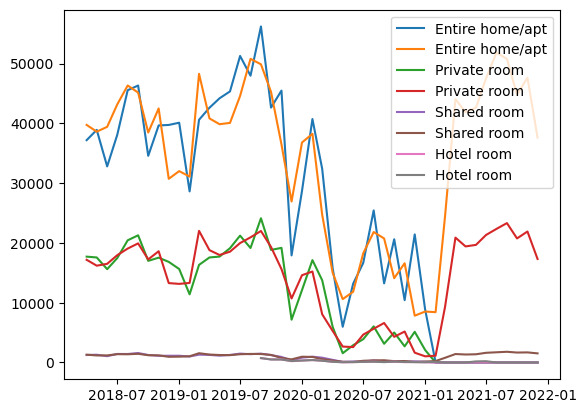

In [53]:
# by room type
rt = ['Entire home/apt','Private room','Shared room','Hotel room']
outdf_r = pd.concat([outdf,outdf_])
df_rt = outdf_r.set_index(['date','room_type'])
df_rt = df_rt.groupby(['date','room_type'])['pred_mr','month_review'].sum()
df_rt = df_rt.reset_index()

df_rt['time'] = list(range(0,len(df_rt)))
for i in rt:
    plt.plot(df_rt.loc[df_rt['room_type']==i,'date'],df_rt.loc[df_rt['room_type']==i,'month_review'], label = i)
    plt.plot(df_rt.loc[df_rt['room_type']==i,'date'],df_rt.loc[df_rt['room_type']==i,'pred_mr'], label = i)
    plt.legend()

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_27897/2106943996.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


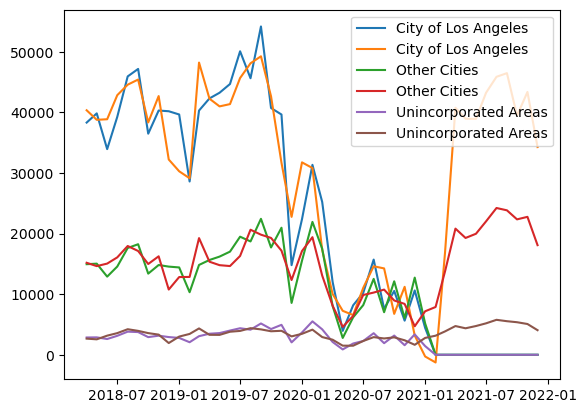

In [55]:
# by neighbourhood_group
ng = ['City of Los Angeles','Other Cities','Unincorporated Areas']
df_rt = outdf.set_index(['date','neighbourhood_group'])
df_rt = df_rt.groupby(['date','neighbourhood_group'])['pred_mr','month_review'].sum()
df_rt = df_rt.reset_index()

df_rt['time'] = list(range(0,len(df_rt)))
for i in ng:
    plt.plot(df_rt.loc[df_rt['neighbourhood_group']==i,'date'],df_rt.loc[df_rt['neighbourhood_group']==i,'month_review'], label = i)
    plt.plot(df_rt.loc[df_rt['neighbourhood_group']==i,'date'],df_rt.loc[df_rt['neighbourhood_group']==i,'pred_mr'], label = i)
    plt.legend()

In [56]:
# df_pred = outdf.set_index(['date','neighbourhood_group'])
df_pred = outdf_r.groupby(['date'])['pred_mr','month_review'].sum()
df_pred = df_pred.reset_index()

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_27897/3922731641.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [57]:
accuracy2(df_pred.loc[df_rt['date']<='2021-01-01','pred_mr'],df_pred.loc[df_rt['date']<='2021-01-01','month_review'])

,MAPE(%)
trn,15.240063
tst,95.204989


# Smoothing-month review

## By month

In [102]:
a2 = a1.reset_index(drop=True)
s = a2.groupby('date')['month_review'].sum()
m = es(s.loc[s.index<='2020-10-01'],trend='add',seasonal='add',seasonal_periods=12).fit()
fitted = m.fittedvalues
pred = m.forecast(3)

p = pd.concat([fitted,pred])

p = p.replace(p.values[-4:],[0,7525.66779742,0,0])

accuracy2(s,p)


/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/Users/shawnspokemonworld/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


,MAPE(%)
trn,39.565662
tst,81.18536
